In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41447374 entries, 0 to 41447373
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   index                      int64 
 1   CUSTOMER_NUMBER            object
 2   ENTERPRISE_ACCOUNT_NO      object
 3   ENTERPRISE_ACCOUNT_NAME    object
 4   NATIONAL_ACCOUNT           object
 5   PAYER                      object
 6   DOCUMENT_DATE_IN_DOCUMENT  dbdate
 7   DOCUMENT_TYPE              object
 8   POSTING_KEY_NAME           object
 9   AMOUNT_IN_LOCAL_CURRENCY   object
 10  CREDIT_CONTROL_AREA        object
 11  AR_STATUS                  object
 12  PAYMENT_DATE               dbdate
dtypes: dbdate(2), int64(1), object(10)
memory usage: 4.0+ GB


In [7]:
# df['PAYMENT_DATE']=pd.to_datetime(df['PAYMENT_DATE'])
# df.query('"2024-01-01" >=PAYMENT_DATE')

In [8]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df.reset_index(inplace = True)


In [9]:
def calc_WAPD(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= PAYMENT_DATE >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum()/ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [10]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [11]:
def search_EAN(ENTERPRISE_ACCOUNT_NO):
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [12]:
def search_NAT(NATIONAL_ACCOUNT):
    None

# **********************************************************************************************************

# Visualization

## Customer

In [13]:
customer = "2057194397"
t = search_customer(customer)

In [14]:
t

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,WAPD,90_days_ago
0,1796581,3635214,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,31,82974.2900,30.6143,2022-06-04
1,1797912,3636696,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,203.8800,PD,CLEAR,2022-09-02,31,6320.2800,30.6143,2022-06-04
2,1797913,3636697,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,29,1116.5000,30.6143,2022-06-04
3,1803223,3642617,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,506.9700,PD,CLEAR,2022-09-02,30,15209.1000,30.6143,2022-06-04
4,1839433,3682839,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,1849.3600,PD,CLEAR,2022-09-02,30,55480.8000,30.6143,2022-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,40897795,48640958,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-10,ZF,01 - Invoice,488.7800,PD,CLEAR,2023-09-08,29,14174.6200,26.6904,2023-06-10
551,40933748,48680821,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-09,ZF,01 - Invoice,187.0600,PD,CLEAR,2023-09-08,30,5611.8000,26.6904,2023-06-10
552,40935129,48682308,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-11,ZF,01 - Invoice,276.2400,PD,CLEAR,2023-09-08,28,7734.7200,26.6904,2023-06-10
553,40937577,48685071,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-07,ZF,01 - Invoice,1258.8800,PD,CLEAR,2023-09-08,32,40284.1600,26.6904,2023-06-10


In [15]:
t['month'] = t['PAYMENT_DATE'].dt.strftime('%b')

In [16]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=t, index=[t.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)

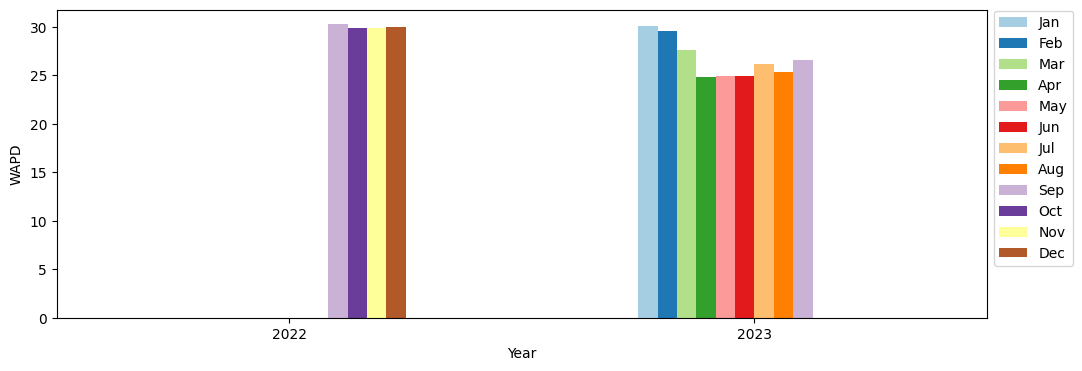

In [17]:
ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [18]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# dfp = pd.pivot_table(data=CONVERSIO_HEALTH_df, index=[CONVERSIO_HEALTH_df.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
# dfp = dfp.reindex(year_order, axis=1)
# dfp

In [19]:
# ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
# _ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

In [20]:
EAN = "7100000645"
s = search_EAN(EAN)

In [21]:
s

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,Sub Payment Date from Invoice Date,Weighted Invoice Value,WAPD,90_days_ago
0,5625,1275571,2057189564,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057189564,2023-04-14,ZF,01 - Invoice,4605.3700,PD,CLEAR,2022-05-31,-318,-1464507.6600,-314.9512,2022-03-02
1,5626,1275572,2057189564,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057189564,2023-04-13,ZF,01 - Invoice,1987.9400,PD,CLEAR,2022-05-31,-317,-630176.9800,-314.9512,2022-03-02
2,5627,1275573,2057189564,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057189564,2023-04-05,ZF,01 - Invoice,1710.2900,PD,CLEAR,2022-05-31,-309,-528479.6100,-314.9512,2022-03-02
3,5628,1275745,2057189564,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057189564,2023-04-14,ZF,01 - Invoice,1929.6300,PD,CLEAR,2022-05-31,-318,-613622.3400,-314.9512,2022-03-02
4,5629,1278198,2057189564,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057189564,2023-04-04,ZF,01 - Invoice,1987.9400,PD,CLEAR,2022-05-31,-308,-612285.5200,-314.9512,2022-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49668,41400472,49211813,2057225796,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057225796,2023-09-11,ZF,01 - Invoice,1809.4400,PD,CLEAR,2023-09-13,2,3618.8800,14.3672,2023-06-15
49669,41400923,49212323,2057211430,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057211430,2023-09-11,ZF,01 - Invoice,6566.0800,PD,CLEAR,2023-09-13,2,13132.1600,14.3672,2023-06-15
49670,41406503,49218428,2057225796,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057225796,2023-09-11,ZF,01 - Invoice,4838.5400,PD,CLEAR,2023-09-13,2,9677.0800,14.3672,2023-06-15
49671,41409683,49221919,2057225796,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057225796,2023-09-11,ZF,01 - Invoice,4240.4800,PD,CLEAR,2023-09-13,2,8480.9600,14.3672,2023-06-15


In [22]:
s['month'] = s['PAYMENT_DATE'].dt.strftime('%b')

In [23]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=s, index=[s.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)
dfp

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,-314.9512,NaN,NaN,6.5987,7.9162,8.0159,7.9692,7.7810
2023,8.1128,8.3786,8.5274,8.2571,8.0526,10.6899,13.9253,14.1208,14.3996,NaN,NaN,NaN


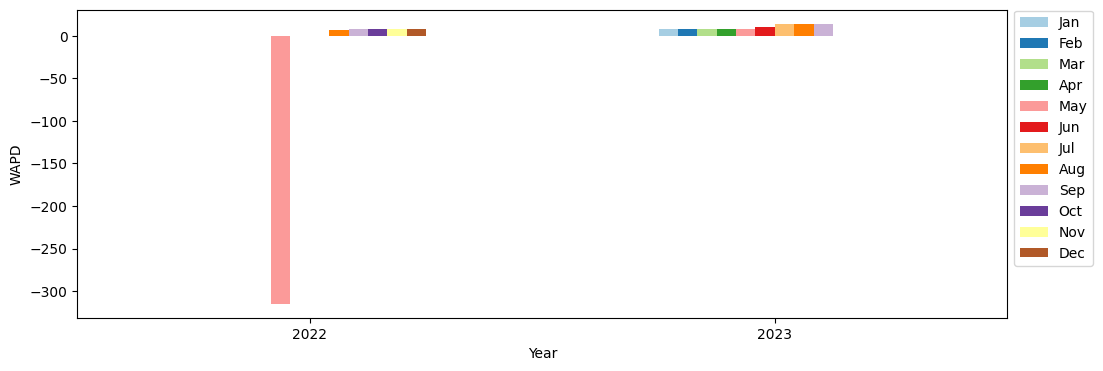

In [24]:
ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [25]:

# ss= s[(s['PAYMENT_DATE'].dt.year == 1970) | (s['PAYMENT_DATE'] >= sixmonthago)]

## National Account